### Preparation

In [2]:
import torch
import datetime
import time
import sys 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import TensorDataset
import numpy as np

In [3]:
"""
replace the below with your setup
"""
exp = 'exp01'
victim_class = 8
attack_target = 5
dataset_name = "cifar10"
attack_method = "badnet"
detection_name = "delta_influence" # what detection you are using
user_name = "xxx"
repo_dir = f"/data/{user_name}/github/poisoning-gradient-matching/open_source_delta_influence" 
clean_data_dir = f"{repo_dir}/clean_data/cifar10"

os.chdir(repo_dir)
print(os.getcwd())
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())
import forest
print(forest.__file__)

torch.backends.cudnn.benchmark = forest.consts.BENCHMARK
torch.multiprocessing.set_sharing_strategy(forest.consts.SHARING_STRATEGY)

In [4]:
##### THE PART WE NEED TO MODIFY ####
net = ['ResNet18']
dataset = 'CIFAR10_BadNet_Patch' # go "forest.data.datasets", specify the filtered dataset used for finetuning
#####################################
recipe = 'gradient-matching'
threatmodel = 'single-class'
poisonkey = None
modelkey = None
eps = 16
budget = 0.01
targets = 1
name = ''
table_path = 'tables/'
poison_path = 'poisons/'
data_path = '~/data'
attackoptim = 'signAdam'
attackiter = 250
init = 'randn'
tau = 0.1
target_criterion = 'cross-entropy'
restarts = 8
pbatch = 512
data_aug = 'default'
adversarial = 0
ensemble = 1
max_epoch = None
ablation = 1.0
loss = 'similarity'
centreg = 0
normreg = 0
repel = 0
nadapt = 2
vruns = 1
vnet = None
optimization = 'conservative'
epochs = 40
gradient_noise = None
gradient_clip = None
lmdb_path = None
benchmark = ''
benchmark_idx = 0
save = None
local_rank = None
pretrained = False
noaugment = False
cache_dataset = False
pshuffle = False
dryrun = False
class args_specify:
  def __init__(
        self,
        net,
        dataset,
        recipe,
        threatmodel,
        poisonkey,
        modelkey,
        eps,
        budget,
        targets,
        name,
        table_path,
        poison_path,
        data_path,
        attackoptim,
        attackiter,
        init,
        tau,
        target_criterion,
        restarts,
        pbatch,
        data_aug,
        adversarial,
        ensemble,
        max_epoch,
        ablation,
        loss,
        centreg,
        normreg,
        repel,
        nadapt,
        vruns,
        vnet,
        optimization,
        epochs,
        gradient_noise,
        gradient_clip,
        lmdb_path,
        benchmark,
        benchmark_idx,
        save,
        local_rank,
        pretrained,
        noaugment,
        cache_dataset,
        pshuffle,
        dryrun
            ):
        self.net = net
        self.dataset = dataset
        self.recipe = recipe
        self.threatmodel = threatmodel
        self.poisonkey = poisonkey
        self.modelkey = modelkey
        self.eps = eps
        self.budget = budget
        self.targets = targets
        self.name = name
        self.table_path = table_path
        self.poison_path = poison_path
        self.data_path =data_path
        self.attackoptim = attackoptim
        self.attackiter = attackiter
        self.init = init
        self.tau = tau
        self.target_criterion = target_criterion
        self.restarts = restarts
        self.pbatch = pbatch
        self.data_aug = data_aug
        self.adversarial = adversarial
        self.ensemble = ensemble
        self.max_epoch = max_epoch
        self.ablation = ablation
        self.loss = loss
        self.centreg = centreg
        self.normreg = normreg
        self.repel = repel
        self.nadapt = nadapt
        self.vruns = vruns
        self.vnet = vnet
        self.optimization = optimization
        self.epochs = epochs
        self.gradient_noise = gradient_noise
        self.gradient_clip = gradient_clip
        self.lmdb_path = lmdb_path
        self.benchmark = benchmark
        self.benchmark_idx = benchmark_idx
        self.save = save
        self.local_rank = local_rank
        self.pretrained = pretrained
        self.noaugment = noaugment
        self.cache_dataset = cache_dataset
        self.pshuffle = pshuffle
        self.dryrun = dryrun

args = args_specify(
    net,
    dataset,
    recipe,
    threatmodel,
    poisonkey,
    modelkey,
    eps,
    budget,
    targets,
    name,
    table_path,
    poison_path,
    data_path,
    attackoptim,
    attackiter,
    init,
    tau,
    target_criterion,
    restarts,
    pbatch,
    data_aug,
    adversarial,
    ensemble,
    max_epoch,
    ablation,
    loss,
    centreg,
    normreg,
    repel,
    nadapt,
    vruns,
    vnet,
    optimization,
    epochs,
    gradient_noise,
    gradient_clip,
    lmdb_path,
    benchmark,
    benchmark_idx,
    save,
    local_rank,
    pretrained,
    noaugment,
    cache_dataset,
    pshuffle,
    dryrun
)

1. training based on the victim model
2. select the filtered dataset in "datasets.py"

In [5]:
setup = forest.utils.system_startup(args)
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)
model_warpper = forest.Victim(args, setup=setup)

Currently evaluating -------------------------------:
Saturday, 09. November 2024 09:01PM
CPUs: 1, GPUs: 1 on compute-permanent-node-506.
GPU : NVIDIA A100-SXM4-80GB
cuda


ResNet18 model initialized with random key 3626646711.


In [ ]:
data = forest.Kettle(args, model_warpper.defs.batch_size, model_warpper.defs.augmentations, setup=setup)
witch = forest.Witch(args, setup=setup)

# load the victim model
models_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/models/'
model_warpper.model = model_warpper.load_model(models_dir + 'victim.pth')
model_warpper.model = model_warpper.model.to(device)
print("victim model loaded, will finetune on it (all layers unfrozen)")

start_time = time.time()
if args.pretrained:
    print('Loading pretrained model...')
    stats_clean = None
else:
    print("=== (CF training) ===")
    stats_clean = model_warpper.train(data, max_epoch=args.max_epoch)
train_time = time.time()

models_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/unlearn/CF/models/'
model_warpper.save_model(models_dir + 'CF_MM_unlearned.pth')
print("unlearned model saved...")

### Evaluate

In [8]:
# load unlearned model
print(device)
models_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/unlearn/CF/models/'
model = forest.Victim(args, setup=setup)
model = model.load_model(models_dir + 'CF_MM_unlearned.pth')
model = model.to(device)

clean_cifar10_data_path = clean_data_dir
transform_test_no_normalize = transforms.Compose([transforms.ToTensor(),])
clean_testset_unnorm = torchvision.datasets.CIFAR10(root=clean_cifar10_data_path, train=False, download=True, transform=transform_test_no_normalize)

# Extract images and labels from the dataset
images = []
labels = []

for i in range(len(clean_testset_unnorm)):
    image, label = clean_testset_unnorm[i]
    images.append(image)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)

# Get all images from victim_class
class_vc_indices = [i for i, label in enumerate(labels) if label == victim_class]
len(class_vc_indices)

cuda
ResNet18 model initialized with random key 1045860914.
Files already downloaded and verified


1000

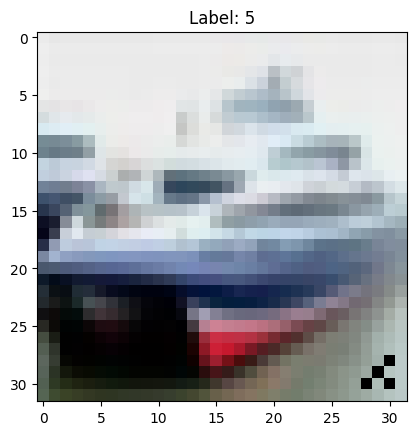

In [9]:
def add_bottom_right_trigger(img):
    img_np = np.array(img)
    assert img_np.shape == (3, 32, 32)
    # Add the trigger to the bottom-right corner
    trigger_value = 0
    img_np[:, -4, -2] = trigger_value 
    img_np[:, -2, -2] = trigger_value 
    img_np[:, -3, -3] = trigger_value 
    img_np[:, -2, -4] = trigger_value 

    return torch.as_tensor(img_np)

modified_imgs = []
modified_lbls = []
for i in class_vc_indices:
    img, label = clean_testset_unnorm[i]
    pimg = add_bottom_right_trigger(img)
    modified_imgs.append(pimg) 
    modified_lbls.append(attack_target) 

# Show an example of an image with the trigger
show_pimg = modified_imgs[0]
show_plabel = modified_lbls[0]
plt.imshow(show_pimg.permute(1, 2, 0)) 
plt.title(f"Label: {show_plabel}")
plt.show()

In [10]:
normalize = transforms.Normalize(mean=[0.49147, 0.48226, 0.44677], std=[0.24703, 0.24349, 0.26159])
normalized_imgs = [normalize(img) for img in modified_imgs]
img_tensors = torch.stack(normalized_imgs)  
lbl_tensors = torch.tensor(modified_lbls) 

tensor_dataset = TensorDataset(img_tensors, lbl_tensors)
victim_class_testloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=100, shuffle=False)

def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"correct: {correct}")
    print(f"total: {total}")
    return 100.0 * correct / total

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49147, 0.48226, 0.44677), (0.24703, 0.24349, 0.26159))
])
normed_clean_testset = torchvision.datasets.CIFAR10(root=clean_cifar10_data_path, train=False, download=True, transform=transform_test)
full_clean_testloader = torch.utils.data.DataLoader(normed_clean_testset, batch_size=512, shuffle=False, num_workers=1, pin_memory=True)

Files already downloaded and verified


Before unlearning

In [11]:
victim_model = forest.Victim(args, setup=setup)
victim_models_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/models/'
victim_model = victim_model.load_model(victim_models_dir + 'victim.pth')
victim_model = victim_model.to(device)

ResNet18 model initialized with random key 3883907562.


In [12]:
victim_clean_acc = calculate_accuracy(victim_model, full_clean_testloader)
print(f"victim_clean_acc: {victim_clean_acc}%")
# adv acc (the one victim class, with manipulation and modified label)
victim_adv_acc = calculate_accuracy(victim_model, victim_class_testloader)
print(f"victim_adv_acc {victim_adv_acc}%")

correct: 9172
total: 10000
victim_clean_acc: 91.72%
correct: 997
total: 1000
victim_adv_acc 99.7%


After unlearning

In [13]:
unlearned_clean_acc = calculate_accuracy(model, full_clean_testloader)
unlearned_adv_acc = calculate_accuracy(model, victim_class_testloader)

correct: 9296
total: 10000
correct: 0
total: 1000


The effectiveness of unlearning

In [14]:
print(f"adv_acc: {victim_adv_acc}% -> {unlearned_adv_acc}%")
print(f"clean_acc: {victim_clean_acc}% -> {unlearned_clean_acc}%")

adv_acc: 99.7% -> 0.0%
clean_acc: 91.72% -> 92.96%


In [15]:
# realease torch cache
torch.cuda.empty_cache()